In [1]:
#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
import numpy as np
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
# convert series to supervised learning & normalize input variables
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def data_preparation(df):
    # Get names of indexes for which column temporarily_unable_test has value 1000
    index = df[ df['number_busy'] > 2000 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Get names of indexes for which column temporarily_unable_test has value 1000
    index = df[ df['temporarily_unable_test'] > 1000 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['followup_tests'] = np.log(df['followup_tests'] + 1)
    
    # Get names of indexes for which column outage_hrs has value > 300 
    index = df[ df['quality_too_poor'] > 300 ].index
    # Delete these row indexes from dataFrame
    df.drop(index , inplace=True)
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['outage_hrs'] = np.log(df['outage_hrs'])
    
    # Use a log transformation to decrease the impact of extreme values in column followup_tests
    df['numbers_tested'] = np.log(df['numbers_tested'])
    
    #df.drop(['followup_tests','outage_hrs', 'numbers_tested'], inplace=True, axis=1)
    
    return df

In [4]:
# load dataset
df = read_csv('../reports/company_report_1.csv', header=0, index_col="time")
#df = data_preparation(df)
df = df[['volume_tests', 'date', 'month', 'is_weekend', 'quality_too_poor', 'number_busy', 'temporarily_unable_test', 'outage_hrs', 'number_test_types', 'numbers_tested', 'min_commit']]
df = df.dropna(axis='columns')
values = df.values

# specify the number of days and features 
n_days = 7
n_features = df.shape[1]

# # integer encode direction
# encoder = LabelEncoder()
# values[:,2] = encoder.fit_transform(values[:,2])

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)

(819, 88)


In [5]:
# split into train and test sets
values = reframed.values

train_size = int(len(values) * 0.80)
test_size = len(values) - train_size
train, test = values[:train_size,:], values[train_size:,:]

# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(655, 77) 655 (655,)
(655, 7, 11) (655,) (164, 7, 11) (164,)


Train on 655 samples, validate on 164 samples
Epoch 1/100
655/655 - 3s - loss: 0.3160 - accuracy: 0.0015 - val_loss: 0.2046 - val_accuracy: 0.0000e+00
Epoch 2/100
655/655 - 0s - loss: 0.2027 - accuracy: 0.0015 - val_loss: 0.1071 - val_accuracy: 0.0000e+00
Epoch 3/100
655/655 - 0s - loss: 0.1257 - accuracy: 0.0015 - val_loss: 0.1423 - val_accuracy: 0.0000e+00
Epoch 4/100
655/655 - 0s - loss: 0.1202 - accuracy: 0.0015 - val_loss: 0.1023 - val_accuracy: 0.0000e+00
Epoch 5/100
655/655 - 0s - loss: 0.1029 - accuracy: 0.0015 - val_loss: 0.0925 - val_accuracy: 0.0000e+00
Epoch 6/100
655/655 - 0s - loss: 0.1101 - accuracy: 0.0015 - val_loss: 0.0923 - val_accuracy: 0.0000e+00
Epoch 7/100
655/655 - 0s - loss: 0.0947 - accuracy: 0.0015 - val_loss: 0.0983 - val_accuracy: 0.0000e+00
Epoch 8/100
655/655 - 0s - loss: 0.0911 - accuracy: 0.0015 - val_loss: 0.0910 - val_accuracy: 0.0000e+00
Epoch 9/100
655/655 - 0s - loss: 0.0895 - accuracy: 0.0015 - val_loss: 0.0837 - val_accuracy: 0.0000e+00
Epoch 10/

Epoch 78/100
655/655 - 0s - loss: 0.0528 - accuracy: 0.0015 - val_loss: 0.1135 - val_accuracy: 0.0000e+00
Epoch 79/100
655/655 - 0s - loss: 0.0523 - accuracy: 0.0015 - val_loss: 0.1048 - val_accuracy: 0.0000e+00
Epoch 80/100
655/655 - 0s - loss: 0.0531 - accuracy: 0.0015 - val_loss: 0.1117 - val_accuracy: 0.0000e+00
Epoch 81/100
655/655 - 0s - loss: 0.0543 - accuracy: 0.0015 - val_loss: 0.1115 - val_accuracy: 0.0000e+00
Epoch 82/100
655/655 - 0s - loss: 0.0523 - accuracy: 0.0015 - val_loss: 0.0979 - val_accuracy: 0.0000e+00
Epoch 83/100
655/655 - 0s - loss: 0.0532 - accuracy: 0.0015 - val_loss: 0.1080 - val_accuracy: 0.0000e+00
Epoch 84/100
655/655 - 0s - loss: 0.0524 - accuracy: 0.0015 - val_loss: 0.1151 - val_accuracy: 0.0000e+00
Epoch 85/100
655/655 - 0s - loss: 0.0535 - accuracy: 0.0015 - val_loss: 0.1042 - val_accuracy: 0.0000e+00
Epoch 86/100
655/655 - 0s - loss: 0.0520 - accuracy: 0.0015 - val_loss: 0.1036 - val_accuracy: 0.0000e+00
Epoch 87/100
655/655 - 0s - loss: 0.0516 - acc

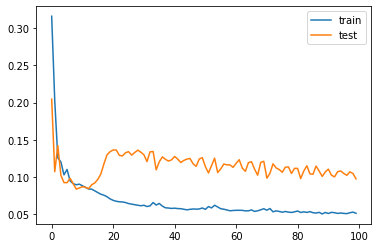

In [6]:
# design LSTM Model
model = Sequential()

model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1, kernel_initializer='lecun_uniform', activation='hard_sigmoid'))
optimizer = Adam(lr=0.001)
model.compile(loss='mae', optimizer=optimizer, metrics=['accuracy'])

# fit Model
history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# plot loss history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [7]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1172.456


In [8]:
# Score model
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
score = model.evaluate(test_X, test_y, verbose=0)
print('Test loss:%.2f%%' % (score[0] * 100))
print('Test accuracy:%.2f%%' % (score[1] * 100))

Test loss:9.74%
Test accuracy:0.00%


In [9]:
# print predicted vs expected
num_days = 210
accuracy_scores = []
for i in range(len(inv_y[:num_days])):
    if inv_y[i] > inv_yhat[i]:
        score = inv_yhat[i] / inv_y[i] * 100
        accuracy_scores.append(score)
    else:
        score = inv_y[i] / inv_yhat[i] * 100
        accuracy_scores.append(score)
    print('Day=%d, Expected=%.2f, Predicted=%.2f, Accuracy=%.2f%%' % (i+1, inv_y[i], inv_yhat[i], score ))
print("%.2f%% (+/- %.2f%%)" % (np.mean(accuracy_scores), np.std(accuracy_scores)))

Day=1, Expected=2494.00, Predicted=2075.86, Accuracy=83.23%
Day=2, Expected=487.00, Predicted=1308.67, Accuracy=37.21%
Day=3, Expected=480.00, Predicted=1006.81, Accuracy=47.68%
Day=4, Expected=2821.00, Predicted=1999.25, Accuracy=70.87%
Day=5, Expected=3049.00, Predicted=2378.31, Accuracy=78.00%
Day=6, Expected=2111.00, Predicted=2441.09, Accuracy=86.48%
Day=7, Expected=2279.00, Predicted=2445.21, Accuracy=93.20%
Day=8, Expected=1840.00, Predicted=2435.55, Accuracy=75.55%
Day=9, Expected=1056.00, Predicted=1187.48, Accuracy=88.93%
Day=10, Expected=480.00, Predicted=1001.26, Accuracy=47.94%
Day=11, Expected=1801.00, Predicted=2141.47, Accuracy=84.10%
Day=12, Expected=2023.00, Predicted=2219.52, Accuracy=91.15%
Day=13, Expected=1883.00, Predicted=2122.50, Accuracy=88.72%
Day=14, Expected=2565.00, Predicted=2113.11, Accuracy=82.38%
Day=15, Expected=1910.00, Predicted=2159.51, Accuracy=88.45%
Day=16, Expected=333.00, Predicted=1483.45, Accuracy=22.45%
Day=17, Expected=537.00, Predicted=12

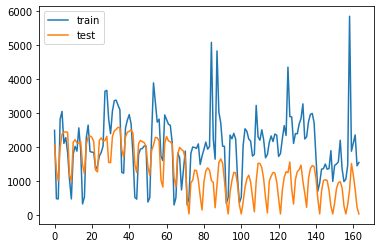

In [10]:
# plot actual vs prediction
num_days = 210
pyplot.plot(list(inv_y[:num_days]), label='train')
pyplot.plot(inv_yhat[:num_days], label='test')
pyplot.legend()
pyplot.show()